In [1]:
# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# [[논문 구현] PyTorch로 LeNet-5(1998) 구현하기](https://deep-learning-study.tistory.com/503?category=983681)
- 220407 
    - 실행 success 
- 220408
    - test? valid? 데이터를 헷갈리게 써놓음.. -> 수정해보자
    - dataloader에서는 분리가 가능한 듯?
    - 일단 test -> valid 용어 통일해야 함
- 220411
    - dataloader에서는 train_data, valid_data type이 subset이어도 정상적으로 작동함
    - [CNN, data augmentation X (pytorch, test acc: 74.2)](https://dacon.io/competitions/official/235874/codeshare/4610?page=1&dtype=recent)에서 제시한 test 코드를 보고 정확도 예측 구현
    - **train, valid, test** 모두 구현 완료!

## CUDA check
- 사용가능한 GPU 확인하기

In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cpu


## MNIST dataset load

In [3]:
# 1. MNIST dataset에 적용할 transformation 객체 생성
from torchvision import transforms
data_transform = transforms.Compose([transforms.Resize((32, 32)),
                                     transforms.ToTensor(),
                                    ])

# 2. MNIST dataset load
from torchvision import datasets

path2data = './data'
train_data = datasets.MNIST(path2data, train = True, download = True, transform = data_transform)
test_data = datasets.MNIST(path2data, train = False, download = True, transform = data_transform)

from torch.utils.data.dataset import random_split
# test_data와 type이 달라서 train_data.data, train_data.targets는 적용이 안되지만
# 이후 dataloader에서는 정상적으로 작동? 
train_data, val_data = random_split(train_data, [55000, 5000])

# 3. dataloader 생성하기 (subset 이후)
from torch.utils.data import DataLoader

train_dl = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(dataset=val_data, batch_size=32)
test_dl = DataLoader(test_data, batch_size=32)

In [4]:
type(train_data)
type(val_data)
type(test_data)

torch.utils.data.dataset.Subset

torch.utils.data.dataset.Subset

torchvision.datasets.mnist.MNIST

## LeNet-5 modeling

In [8]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    
    # subsampling(pooling) 계층은 여기서 구현 안하네
    # forward에서 구현하는 듯
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.tanh(self.conv1(x)) # C1
        x = F.avg_pool2d(x, 2, 2) # S2 / (x, kernel_h, kernel_w)
        x = F.tanh(self.conv2(x)) # C3
        x = F.avg_pool2d(x, 2, 2) # S4
        x = F.tanh(self.conv3(x)) # C5 / (32, 120, 1, 1)
        x = x.view(-1, 120) # (32, 120)
        x = F.tanh(self.fc1(x)) # F6 / (32, 84)
        x = self.fc2(x) # F7 / (32, 10)
        return F.softmax(x, dim=1)

model = LeNet_5()
print(model)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
# 모델을 cuda or cpu로 전달하기
model.to(device)
print(next(model.parameters()).device)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

cpu


In [10]:
# 모델 summary 확인하기
from torchsummary import summary
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


/Users/lsh/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## loss function, optimizer 정의하기

In [34]:
# 1. loss function 정의하기
loss_func = nn.CrossEntropyLoss(reduction='sum')

# 2. optimizer 정의하기
from torch import optim
opt = optim.Adam(model.parameters(), lr=0.001)

# 3. 현재 learning rate를 계산하는 함수 정의
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
# 4. learning rate scheduler 정의
from torch.optim.lr_scheduler import CosineAnnealingLR
lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-05)

## 학습을 위한 함수 정의

In [12]:
'''⭐️output.argmax(dim=1, keepdim=True)'''
a = torch.Tensor([[1,2,3,4,5],
             [2,3,4,5,6],
             [10,10,11,10,10]])
# np.argmax(a,axis=1)
a.argmax(dim=1, keepdim=False)
pred = a.argmax(dim=1, keepdim=True)
pred
# a.argmax(dim=1, keepdim=False)

'''⭐️target.view_as(pred)'''
# view_as() 함수는 target 텐서를 view_as() 함수 안에 들어가는 인수(pred)의 모양대로 다시 정렬
target = torch.Tensor([4, 3, 2])
target.view_as(pred)

pred.eq(target) # 계산이 틀리게 됨
pred.eq(target.view_as(pred)) # shape을 맞춰줘야 계산이 맞음
pred.eq(target.view_as(pred)).sum().item() # boolean -> int로 형변환 후 sum 계산

'''⭐️for xb, yb in dataset_dl:'''
from torch.utils.data import DataLoader

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
for x, y in train_dl:
    print(x.shape) # (b, c, h, w)
    print(x.ndim)
    print(y.shape) # (b)
    print(y.ndim)
    break

'⭐️output.argmax(dim=1, keepdim=True)'

tensor([4, 4, 2])

tensor([[4],
        [4],
        [2]])

'⭐️target.view_as(pred)'

tensor([[4.],
        [3.],
        [2.]])

tensor([[ True, False, False],
        [ True, False, False],
        [False, False,  True]])

tensor([[ True],
        [False],
        [ True]])

2

'⭐️for xb, yb in dataset_dl:'

torch.Size([32, 1, 32, 32])
4
torch.Size([32])
1


In [13]:
# 1. batch당 performance metric을 계산하는 함수 정의
# output = 10개의 softmax 확률로 구성된 torch.Tensor일 듯
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True) 
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects # pred == target의 개수 (정답을 맞춘 개수)

# 2. batch당 loss를 계산하는 함수 정의
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    corrects = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), corrects # 손실 함수 값, 정답 개수

# 3. epoch당 loss와 performance metric을 계산하는 함수 정의
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_corrects = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        
        # GPU 이용하기 위함
        # 모든 입력에 .to(torch.device('cuda')) 함수를 호출해야 모델에 데이터를 제공할 수 있음
        # https://tutorials.pytorch.kr/recipes/recipes/save_load_across_devices.html
        xb = xb.type(torch.float).to(device) # x
        yb = yb.to(device) # y(target)
        output = model(xb)
        loss_b, corrects_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        # 정답을 맞춘 개수가 존재한다면 한 epoch내에서 batch_size마다 맞춘 개수를 더해줌
        if corrects_b is not None:
            running_corrects += corrects_b
        
        # sanity_check가 True이면 1epoch만 학습함
        if sanity_check is True:
            break
    
    loss = running_loss / float(len_data) # 1epoch내(모든 dataset의 길이에 대한) 손실 함수 값의 평균
    corrects = running_corrects / float(len_data) # 1epoch내(모든 dataset의 길이에 대한) 정답인 비율 계산
    return loss, corrects

⭐️`model.train()`, `model.eval()`
- `nn.Module`에는 train time과 evaluate time에 수행하는 다른 작업을 switching해줄 수 있도록하는 함수를 제공함
- train time과 evaluate time에 서로 다르게 동작해야 하는 것들에는 대표적으로 아래와 같은 것들이 있음
    - Dropout layer
    - BatchNorm layer
- `model.eval()`을 수행하면 evaluation과정에서 사용하지 않을 layer들의 전원을 끔
- evaluation이 끝나면 `model.train()`을 통해 다시 train mode로 변경을 해줘야 함

In [30]:
# 4. train_val 함수 정의 
from tqdm.notebook import tqdm

def train_val(model, params):
    
    # params from where? 내가 나중에 사전 생성해서 설정하는 부분..^^
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    
    loss_history = {'train':[], 'val':[]}
    corrects_history = {'train':[], 'val':[]}
    
    # best model parameter 저장하기
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf') # 양의 무한대
    
    for epoch in tqdm(range(num_epochs)):
        current_lr = get_lr(opt) # 앞서 get_lr 정의함
        print(f'Epoch {epoch}/{num_epochs-1}, current lr={current_lr}')
        
        # 학습 후 loss, corrects 구해서 loss_history, corrects_history list에 각각 append
        model.train()
        train_loss, train_corrects = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        corrects_history['train'].append(train_corrects)
        
        # 학습이 잘 되었는지 test dataset으로 test (학습이 아닌 test이므로 최적화가 필요없음)
        model.eval()
        with torch.no_grad(): # 가중치 초기화 하면서 진행
            val_loss, val_corrects = loss_epoch(model, loss_func, train_dl, sanity_check)
            loss_history['val'].append(val_loss)
            corrects_history['val'].append(val_corrects)
        
        # val_loss가 가장 낮을 때의 모델 weights를 찾기 위한 과정
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')
        
        lr_scheduler.step()
        
        print('train_loss: %.6f, val_loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_corrects))
        print('-'*10)
    
    # best model을 반환하기
    model.load_state_dict(best_model_wts)
    return model, loss_history, corrects_history

## 모델 학습하기

In [31]:
import copy
import os

# 학습된 모델의 가중치를 저장할 폴더 생성
os.makedirs('./models', exist_ok=True)

# 하이퍼파라미터 설정
params_train={'num_epochs': 10,
             'optimizer': opt,
             'loss_func': loss_func,
             'train_dl': train_dl,
             'val_dl': val_dl,
             'sanity_check': False,
             'lr_scheduler': lr_scheduler,
             'path2weights': './models/LeNet-5.pt'}

In [32]:
# 모델 학습하기
model, loss_hist, corrects_hist = train_val(model, params_train)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9, current lr=0.001
Copied best model weights
train_loss: 1.487500, val_loss: 1.483893, accuracy: 97.87
----------
Epoch 1/9, current lr=0.000505
Copied best model weights
train_loss: 1.480210, val_loss: 1.477322, accuracy: 98.48
----------
Epoch 2/9, current lr=1e-05
Copied best model weights
train_loss: 1.476034, val_loss: 1.474919, accuracy: 98.73
----------
Epoch 3/9, current lr=0.0005049999999999999
Copied best model weights
train_loss: 1.477590, val_loss: 1.473575, accuracy: 98.84
----------
Epoch 4/9, current lr=0.001
train_loss: 1.480446, val_loss: 1.476943, accuracy: 98.54
----------
Epoch 5/9, current lr=0.0005050000000000001
Copied best model weights
train_loss: 1.474380, val_loss: 1.471312, accuracy: 99.06
----------
Epoch 6/9, current lr=1e-05
Copied best model weights
train_loss: 1.470829, val_loss: 1.470273, accuracy: 99.15
----------
Epoch 7/9, current lr=0.0005049999999999999
train_loss: 1.472941, val_loss: 1.471575, accuracy: 99.03
----------
Epoch 8/9, curren

In [51]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

def test(dataloader, model, loss_func):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
test(test_dl, model, loss_func)

Test Error: 
 Accuracy: 98.4%, Avg loss: 47.194077 



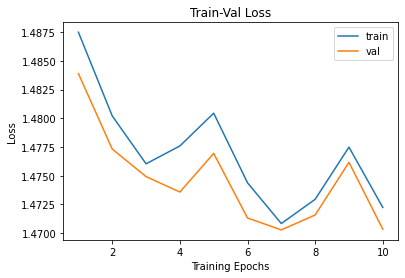

In [36]:
num_epochs=params_train["num_epochs"]

_ = plt.title("Train-Val Loss")
_ = plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
_ = plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
_ = plt.ylabel("Loss")
_ = plt.xlabel("Training Epochs")
_ = plt.legend()
plt.show()

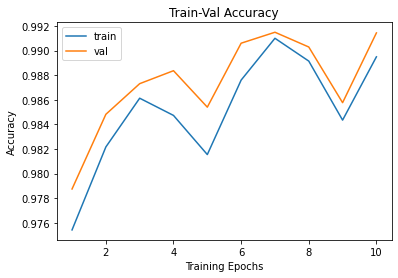

In [37]:
# plot accuracy progress
_ = plt.title("Train-Val Accuracy")
_ = plt.plot(range(1,num_epochs+1),corrects_hist["train"],label="train")
_ = plt.plot(range(1,num_epochs+1),corrects_hist["val"],label="val")
_ = plt.ylabel("Accuracy")
_ = plt.xlabel("Training Epochs")
_ = plt.legend()
plt.show()